# Welter



Monday, May 4, 2016  

## Phase of variability.

part 1

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [4]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

## ASASSN Data from Subo Dong (with aggregation by me)

In [5]:
import pandas as pd

The header contains 3 extraneous octothorpes "###".  Read the data just to get the columns.

In [6]:
fn = '../data/photometry/LkCa4.dat'
names = pd.read_csv(fn, delim_whitespace=True, nrows=0).columns[1:]
dat = pd.read_csv(fn, delim_whitespace=True, names=names, header=0, index_col=False)

In [7]:
dat_agg = pd.read_csv('../data/photometry/LkCa4_ASASSN_aggregated.dat')

## Grankin data from Grankin et al. 2008

In [8]:
grankin_dat = pd.read_csv('../data/photometry/LkCa4_grankin.dat')

In [12]:
vals = grankin_dat.U_B == grankin_dat.U_B

## Grankin bonus data

In [28]:
gr_bonus = pd.read_csv('../data/photometry/LkCa4_2013_grankin_bonus.dat', delim_whitespace=True)
gr_bonus['HJD'] = gr_bonus['HJD+2456000'] + 2456000.0
#gr_bonus.head()

## IGRINS Observation times

In [13]:
IG_OBS_date1 = 2457344.8609722229
IG_OBS_date2 = 2456990.790381945

**date1** is from the data I asked Greg Mace to acquire after discussions at the Seoul IGRINS workshop (Nov. 2015) with DTJ, G. Mace, and G. Herczeg.  
**date2** is data acquired previously that I have not used.

## ESPaDoNs Observation times

In [14]:
#!cat ../data/photometry/ESPaDoNs_LkCa4_obsdates.csv
espadons_obsdates = pd.read_csv('../data/photometry/ESPaDoNs_LkCa4_obsdates.csv', sep='\s+')
espadons_obsdates['BJD'] =  espadons_obsdates['bjd-2456000'] + 2456000.0
#espadons_obsdates

The difference between BJD and JD is a [maximum of 8 minutes](https://en.wikipedia.org/wiki/Barycentric_Julian_Date), which doesn't really matter for our purposes so we will simply call them equivalent for now (the effect is comparable to the exposure times).

## Other data Observation times

**NIRSPEC on Keck**  In an email titled "NIRSPEC data" on January 6, 2016, Greg Herczeg writes:
>order  wavelength  cts(normalized)

>from 28 November 2002


Converting [to JD](http://aa.usno.navy.mil/cgi-bin/aa_jdconv.pl?form=1&year=2002&month=11&day=28&era=1&hr=0&min=0&sec=0.0), we have:

In [15]:
nirspec_date = 2452606.500000

...which could be off by up to 1 day...

## Observation dates plot

In [16]:
sns.set_context('paper')

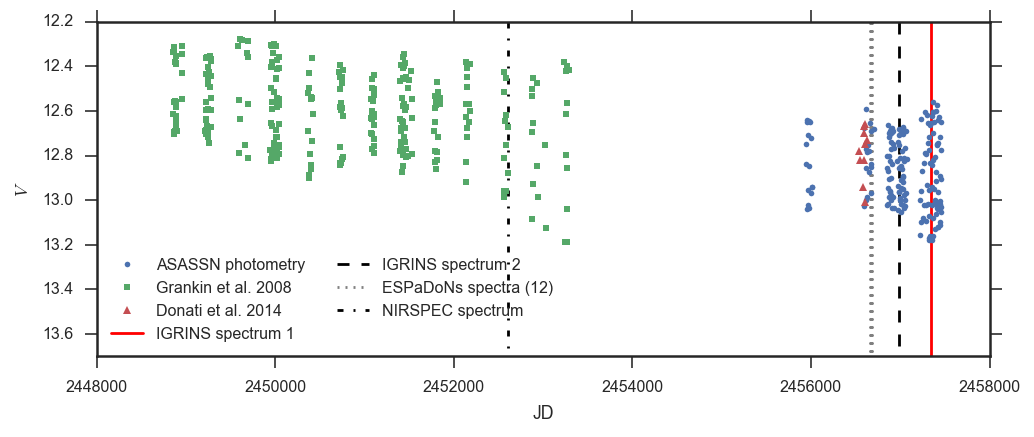

In [35]:
plt.figure(figsize=(8, 3))
plt.plot(dat_agg.JD, dat_agg.mean_mag, '.', label='ASASSN photometry')
plt.plot(grankin_dat.HJD, grankin_dat.Vmag, 's', label='Grankin et al. 2008', ms=3)
plt.plot(gr_bonus.HJD, gr_bonus.V_mag, '^', label='Donati et al. 2014', ms=4)
plt.ylim(13.7, 12.2)
#plt.xlim(2456410, 2457800)
#plt.xlim(2452410, 2457800)

plt.vlines(IG_OBS_date1, 12.2, 13.7, linestyles='solid', colors='red', label='IGRINS spectrum 1')
plt.vlines(IG_OBS_date2, 12.2, 13.7, linestyles='dashed', colors='black', label='IGRINS spectrum 2')


plt.vlines(espadons_obsdates.BJD[0], 12.2, 13.7, linestyles='dotted', colors='gray', label='ESPaDoNs spectra (12)')
for i in np.arange(1, len(espadons_obsdates)-1):
    plt.vlines(espadons_obsdates.BJD[i], 12.2, 13.7, linestyles='dotted', colors='gray')

plt.vlines(nirspec_date, 12.2, 13.7, linestyles='dashdot', colors='black', label='NIRSPEC spectrum')
    
plt.legend(ncol=2, loc='lower left')
plt.xlabel('JD')
plt.ylabel('$V$')
plt.savefig('../document/figures/LkCa4_phot1992-2016.pdf', bbox_inches="tight");

## Model

In [9]:
def lnlike(theta, x, y, yerr):
    A, b0, B, p, lnf = theta
    model = b0 + A*np.sin(2.0*np.pi*(x-B)/p) # + B*np.cos(2.0*np.pi*x/p)
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [10]:
def lnprior(theta):
    A, b0, B, p, lnf = theta
    if (3.3 < p < 3.4) and (0.35 < A < 0.9) and (0 < B < p):
        return 0.0
    return -np.inf

In [11]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [12]:
guess = np.array([0.80,12.9, 2.0, 3.375, -4.0])

In [13]:
ndim, nwalkers = 5, 40
pos = [guess + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [14]:
inds = (dat.JD > 2457060) 

In [15]:
x = dat.JD[inds]
y = dat.mag[inds]
yerr = dat.mag_err[inds]

In [16]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

## Deprecated code to directly forward model the lightcurve

This is probably the wrong approach because you don't want to model the phase

```python
#n_samples = 5000

#output = sampler.run_mcmc(pos, n_samples)

#ws = sampler.chain

#ws.shape

from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 14))
for i in range(0, 5, 1):
    axes[i].plot(ws[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i].set_ylabel(label[i])

#axes[13].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)

sampler.chain.shape

samples = sampler.chain[:, 3000:, :].reshape((-1, ndim))

import corner

fig = corner.corner(samples, labels=["$A$ (mag)", "$b0$ (mag)", "$B$ (mag)", "$p$ (days)", "$\ln{f}$"])
#fig.savefig("triangle.png")

samples.shape

A, b0, B, p, lnf = samples[10000]

x_dense = 2457313.88562 + np.arange(0, 300, 0.1)

x_dense.shape

model = b0 + A*np.sin(2.0*np.pi*(x_dense-B)/p) # + B*np.cos(2.0*np.pi*x/p)
```

```python
plt.figure(figsize=(12, 10))
plt.plot(dat.JD, dat.mag, '.')
plt.ylim(13.5, 12.2)
plt.xlim(2457310,2457310+150)#, 2457390)

plt.vlines(2457341.0, 12.2, 13.5, linestyles='dotted')

plt.plot(x_dense, model)
```

## Phase folded lightcurve analysis

In [21]:
p = 3.374

In [22]:
phased = np.mod(x, p)

In [66]:
phased_IG = np.mod(IG_OBS_date1, p)
phased_IG2 = np.mod(IG_OBS_date2, p)

In [104]:
espadons_obsdates['phased'] = espadons_obsdates.BJD.mod(p)
espadons_obsdates['phase_frac'] = espadons_obsdates.phased/p

In [25]:
dat.UT_date[inds].values[0], dat.UT_date[inds].values[-1]

('2015-02-12.2863084', '2016-03-12.2310206')

In [44]:
sns.set_context('paper')

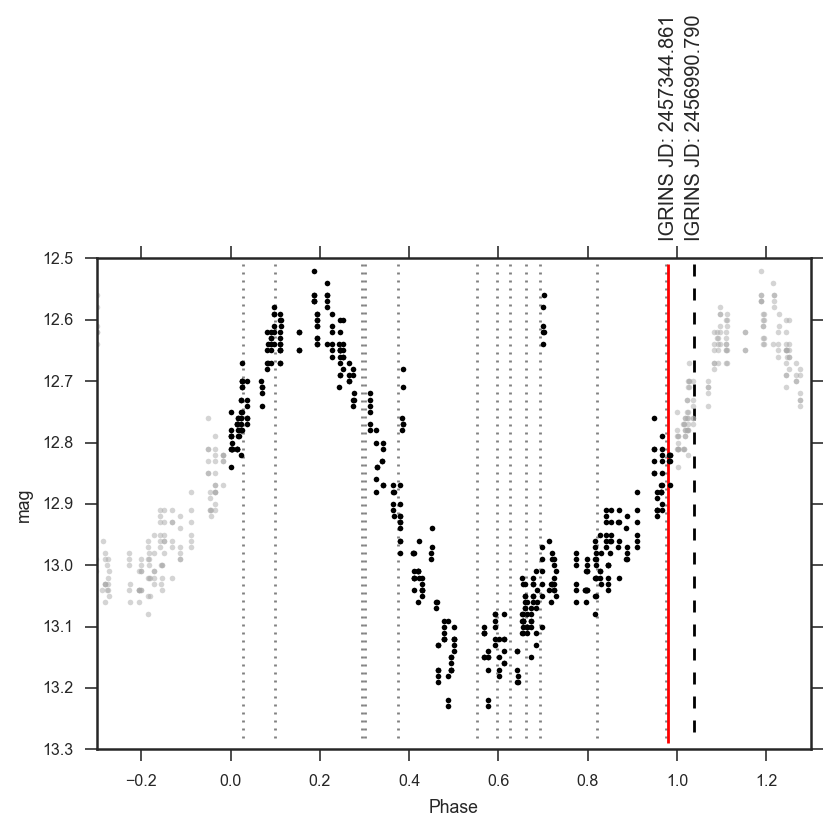

In [111]:
#plt.figure(figsize=(6,6))

for i in range(len(espadons_obsdates)):
    plt.vlines(espadons_obsdates.phase_frac[i], 12.51, 13.29, linestyles='dotted', colors='gray')
    
    
plt.plot(phased/p, y, 'k.')
plt.plot(phased/p+1.0, y, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.plot(phased/p-1.0, y, marker='.', linestyle='none', color='#AAAAAA', alpha=0.5)
plt.vlines(phased_IG/p, 12.51, 13.29, linestyles='solid', colors='red')
plt.vlines(1.0+phased_IG2/p, 12.51, 13.29, linestyles='dashed')
plt.xlabel('Phase')
plt.ylabel('mag')
#plt.title('LkCa4 in ASASSN 2015-2016')
plt.xlim(-0.3, 1.3)
plt.ylim(13.3, 12.5)

plt.text(phased_IG/p-0.02, 12.47, 'IGRINS JD: {:.3f}'.format(IG_OBS_date1), rotation=90, 
        verticalalignment='bottom')

plt.text(1+phased_IG2/p-0.02, 12.47, 'IGRINS JD: {:.3f}'.format(IG_OBS_date2), rotation=90, 
        verticalalignment='bottom')

    

#plt.savefig('../results/fig/phase_folded_lightcurve.pdf')
plt.savefig('../document/figures/ASASSN_phase_labels.pdf', bbox_inches="tight")

In [30]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

In [33]:
periods = np.linspace(3.35, 3.40, 100)

omega = 2.00*np.pi/periods

P_M = multiterm_periodogram(x, y, yerr, omega)
P_LS = lomb_scargle(x, y, yerr, omega)

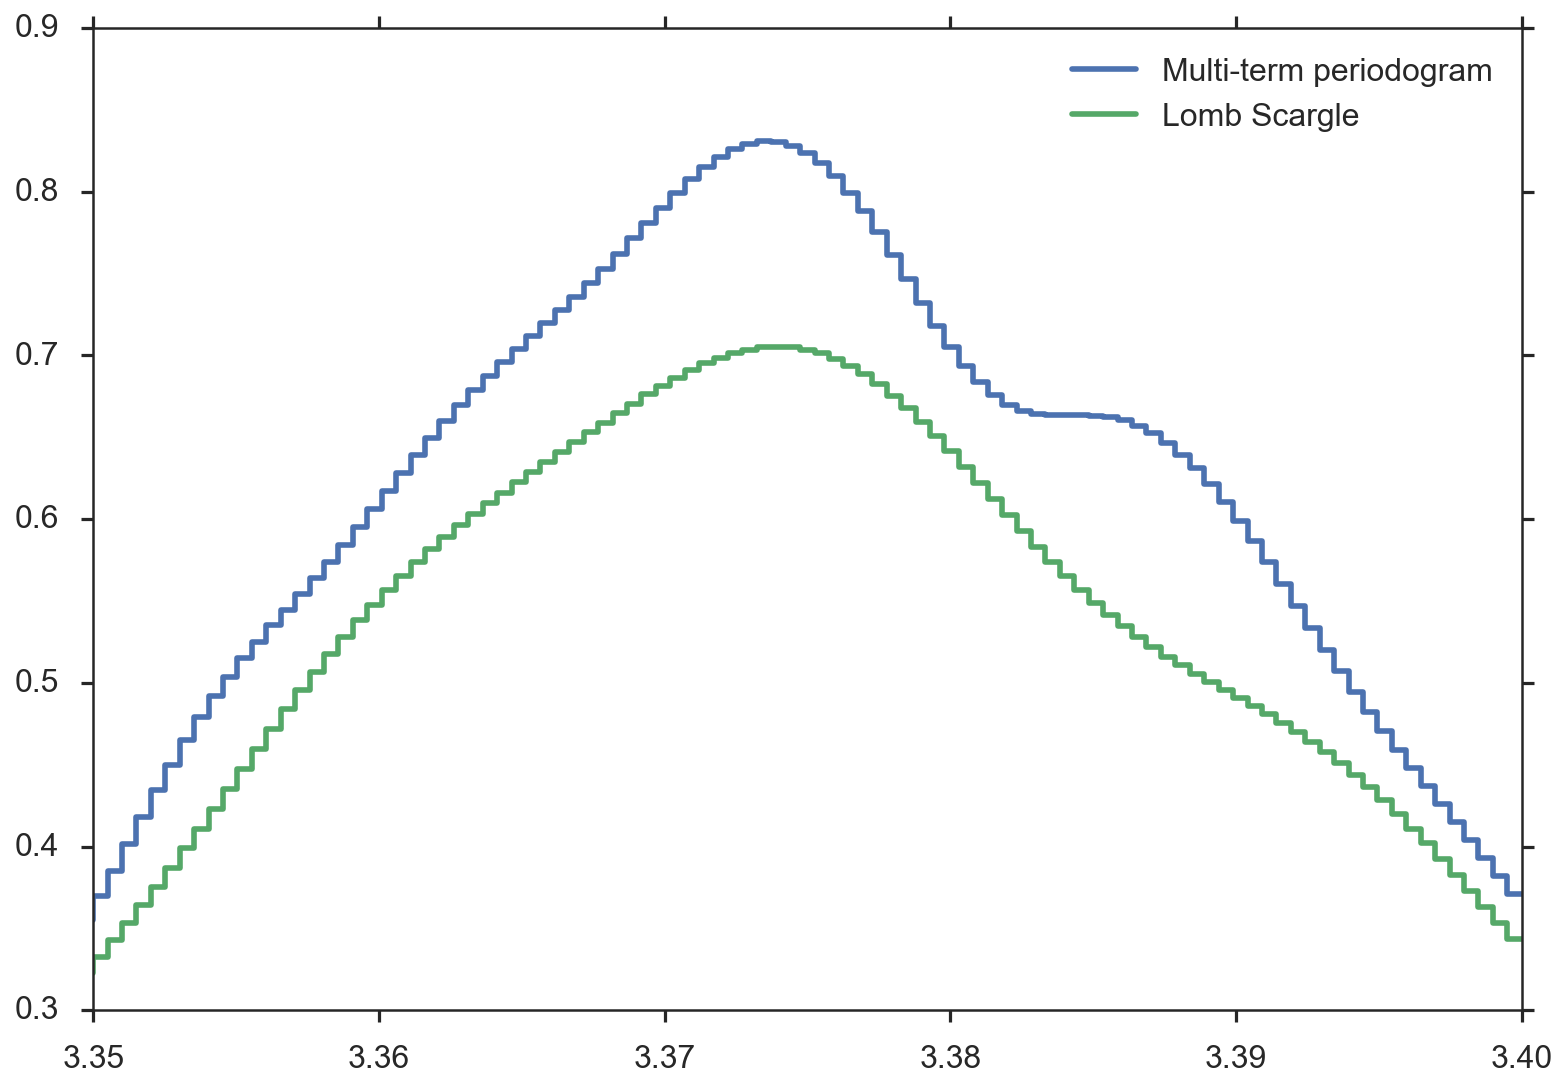

In [34]:
plt.step(periods, P_M, label='Multi-term periodogram')
plt.step(periods, P_LS, label='Lomb Scargle')
plt.legend()

In [35]:
P_LS = lomb_scargle(x, y, yerr, omega)

In [36]:
np.argmax(P_LS), np.argmax(P_M)

(48, 47)

In [37]:
periods[48]

3.374242424242424

In [38]:
import astroML.time_series

In [39]:
mtf = astroML.time_series.MultiTermFit(3.374, 4)

In [40]:
mtf_fit = mtf.fit(x, y, yerr)

In [41]:
#mtf_fit.

In [42]:
phz, yfit = mtf.predict(100)

The end.